In [2]:
import torch
from datasets import package
from torch.utils.data.dataloader import DataLoader
from models import autoencoder, maker
from config import config
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from random import sample
from utils.viewer import make_grid
import similarity

In [4]:
args = config(['--config', 'configs/mnist_smaller.yaml', '--load', 'data/models/autoencoders/mnist/mnist_small/run_39/best'])
torch.cuda.set_device(args.device)

""" data """
datapack = package.datasets[args.dataset_name]
train, test = datapack.make(args.dataset_train_len, args.dataset_test_len, data_root=args.dataroot)
train_l = DataLoader(train, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
test_l = DataLoader(test, batch_size=args.batchsize, shuffle=True, drop_last=True, pin_memory=True)

""" model """
encoder = maker.make_layers(args.model_encoder, type=args.model_type)
decoder = maker.make_layers(args.model_decoder, type=args.model_type)
auto_encoder = autoencoder.LinearAutoEncoder(encoder, decoder, init_weights=args.load is None).to(args.device)
auto_encoder.load_state_dict(torch.load(args.load))

batch = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}


In [5]:
for images, labels in tqdm(train_l):
    for image, label in zip(images, labels):
        batch[label.item()].append(image)

100%|██████████| 468/468 [00:04<00:00, 106.35it/s]


In [6]:
sim_stats = torch.zeros(len(batch), len(batch))

for numeral_left in tqdm(batch):
    for numeral_right in batch:
        length = min(len(batch[numeral_left]), len(batch[numeral_right]), 10)
        left = torch.stack(sample(batch[numeral_left], length)).to(args.device)
        right = torch.stack(sample(batch[numeral_right], length)).to(args.device)
        sim_stats[numeral_left, numeral_right] = similarity.similarity_trace_mean(auto_encoder.encoder,
                                                                                  left.flatten(start_dim=1),
                                                                                  right.flatten(start_dim=1)).mean()


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


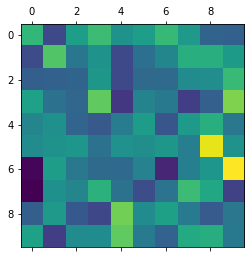

In [7]:
plt.matshow(sim_stats)
plt.show()

In [14]:
def plot_images(s, left, right, diag=None):
    
    if diag is not None:
        items = zip(s, left, right, diag)
    else:
        items = zip(s, left, right)
        
    items = sorted(items, key=lambda sim:sim[0])
    columns = 4 if diag is not None else 3
    width = 4 if diag is None else  4 + len(diag)
    fig, ax = plt.subplots(s.size(0),columns, figsize=(width, s.size(0)))
    
    for i, x in enumerate(items):
        ax[i][0].text(0.5, 0.5, f'{x[0].item():.2f}', fontsize=12, horizontalalignment='center')
        ax[i][1].imshow(x[1].detach().cpu().squeeze(), cmap='gray')
        ax[i][2].imshow(x[2].detach().cpu().squeeze(), cmap='gray')
        if diag is not None:
            diag_str = [f'{d.item():.2f}' for d in x[3]]
            ax[i][3].text(0.5, 0.5, f'{diag_str}', fontsize=12, horizontalalignment='center')
        for j in range(columns):
            ax[i][j].get_xaxis().set_visible(False) # this removes the ticks and numbers for x axis
            ax[i][j].get_yaxis().set_visible(False) # this removes the ticks and numbers for y axis
        
    plt.axis('off') # this rows the rectangular frame 
    fig.show()

/home/duane/PycharmProjects/.venv/similarity/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


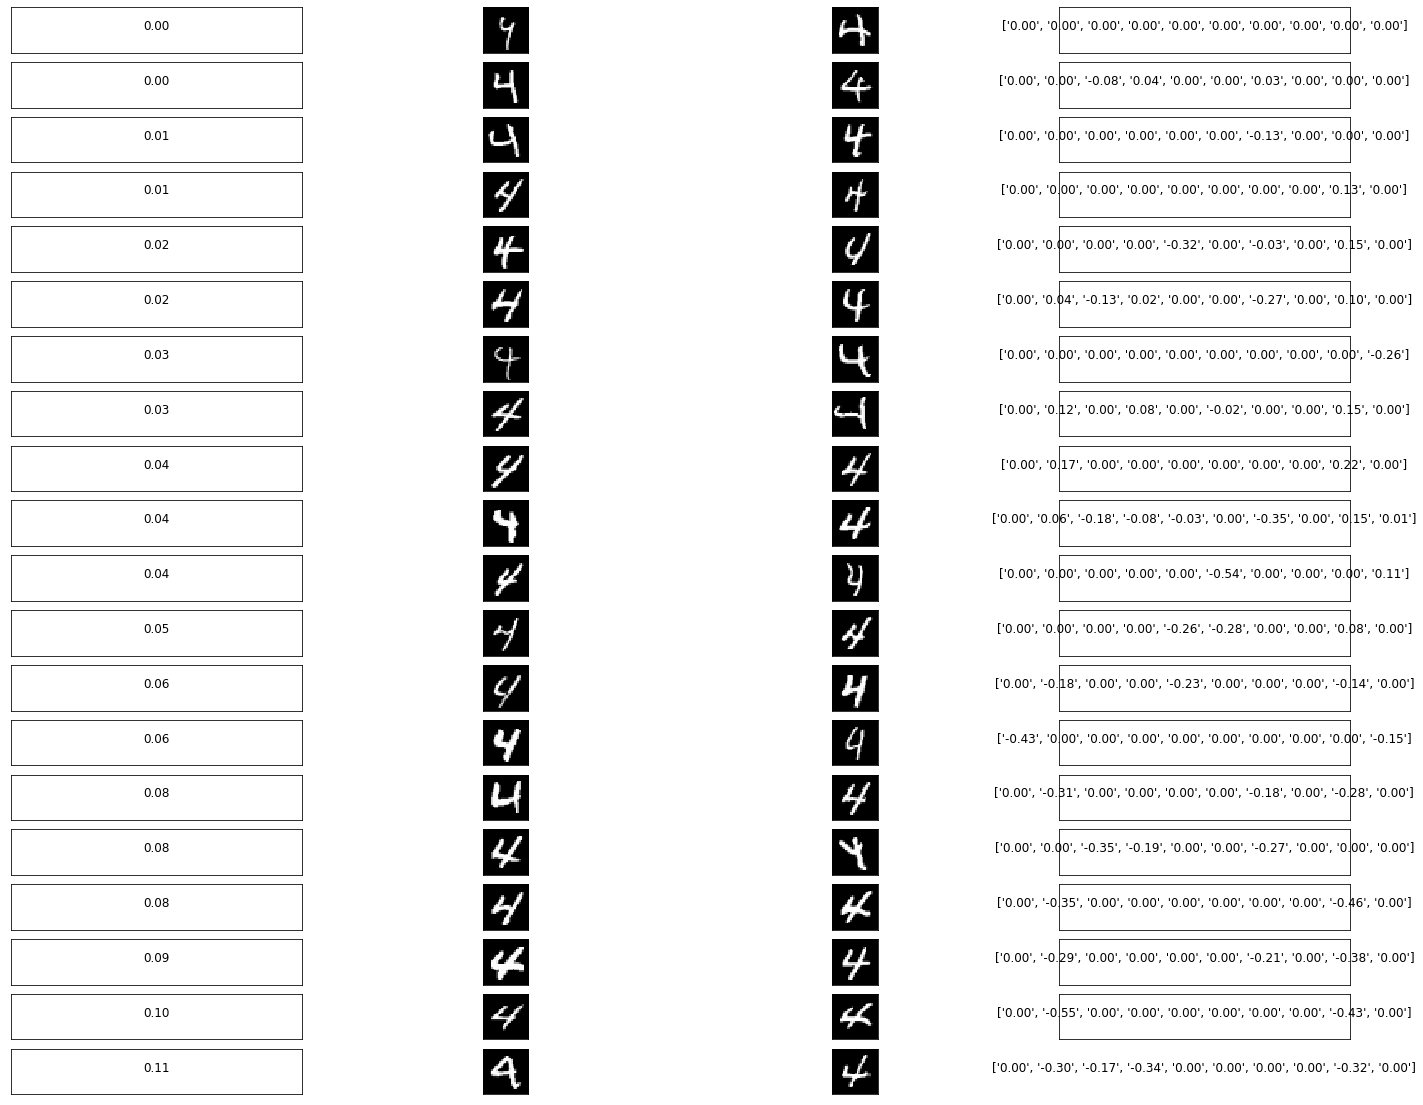

In [15]:
length = 20
left = torch.stack(sample(batch[4], length)).to(args.device)
right = torch.stack(sample(batch[4], length)).to(args.device)

s, d = similarity.similarity_trace_mean(auto_encoder.encoder,
                                    left.flatten(start_dim=1), 
                                    right.flatten(start_dim=1),
                                     return_diag=True)

plot_images(torch.abs(s), left, right, d)

/home/duane/PycharmProjects/.venv/similarity/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


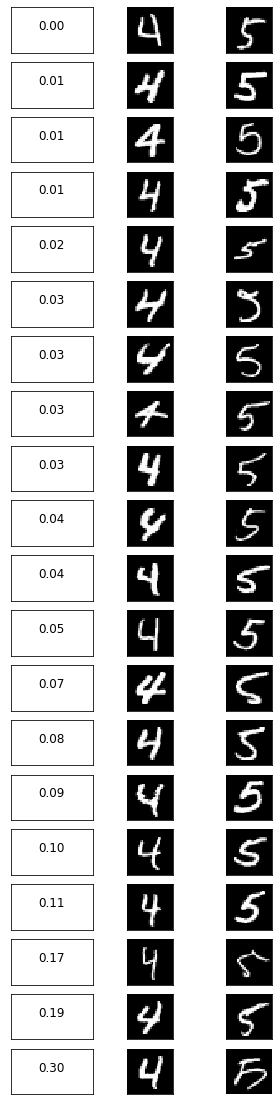

In [11]:
length = 20
left = torch.stack(sample(batch[4], length)).to(args.device)
right = torch.stack(sample(batch[5], length)).to(args.device)

s = similarity.similarity_trace_mean(auto_encoder.encoder,
                                    left.flatten(start_dim=1), 
                                    right.flatten(start_dim=1))

plot_images(torch.abs(s), left, right)